In [1]:
%load_ext autoreload
%autoreload 2

import time

import mujoco as mj
import mujoco.viewer
import mujoco.renderer # Additional import

import numpy as np
from scipy.spatial.transform import Rotation as R

from utility import unit
from controller import Controller
from human import Human

from sensors import Sensors
from video_recorder import Recorder

def move_simple(name, *, t, func, axis=-1, model):
  model.site(name).pos[axis] = func(t)

m = mj.MjModel.from_xml_path('./mjcf/tec.xml')
d = mj.MjData(m)
t = 0

# Create a renderer for data collection
r_rgb = mujoco.renderer.Renderer(m, 480, 640)
r_depth = mujoco.renderer.Renderer(m, 480, 640)
r_seg = mujoco.renderer.Renderer(m, 480, 640)
r_depth.enable_depth_rendering()
r_seg.enable_segmentation_rendering()

# Create a recorder for data collection
sensor = Sensors()
recorder = Recorder(duration=30, 
                    fps=30, 
                    n_cameras=m.cam_user.shape[0], 
                    folder="./")

mujoco.mj_step(m, d)

In [ ]:
with mujoco.viewer.launch_passive(m, d) as viewer:
# Close the viewer automatically after 30 wall-seconds.

    start = time.time()
    while viewer.is_running() and time.time() - start < recorder.duration:
        step_start = time.time()

        # policy
        # mj_step can be replaced with code that also evaluates
        # a policy and applies a contro l signal before stepping the physics.

        move_simple('human1', t=t, func=lambda x: (np.sin(x)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        move_simple('human2', t=t, func=lambda x: (np.sin(x*2)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        move_simple('human3', t=t, func=lambda x: (np.sin(x*3)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        mujoco.mj_step(m, d)
        t += 0.1

        # Get RGB, depth, and segmentation images
        readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)
        # Save images to recorder
        recorder.add_frame(readings)

        # Pick up changes to the physics state, apply perturbations, update options from GUI.
        viewer.sync()

        # Rudimentary time keeping, will drift relative to wall clock.
        time_until_next_step = m.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)
            time.sleep(0.01)

# Save videos
# recorder.show_videos()

In [ ]:
np.save("depth_1.npy", readings[0][:, :, 3])
np.save("depth_2.npy", readings[1][:, :, 3])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(readings[0][:, :, 3])
plt.show()

fig = plt.figure()
plt.imshow(readings[1][:, :, 3])
plt.show()

fig = plt.figure()
plt.imshow(readings[2][:, :, 3])
plt.show()

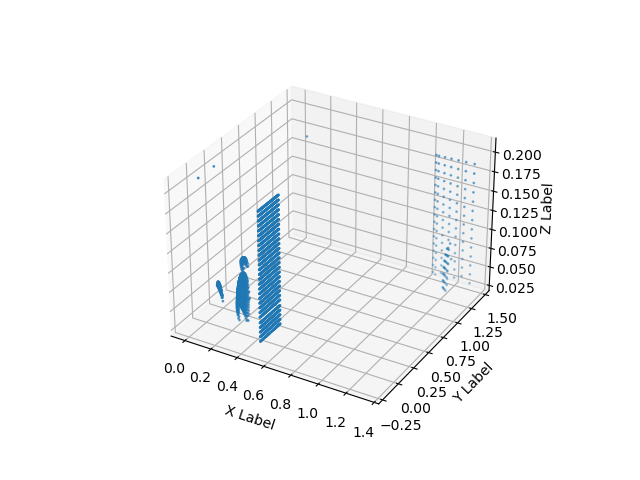

In [6]:
# Retrieve data from the cameras
readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)

poses = []
rotations = []
for i in range(m.cam_user.shape[0]):
    pos = m.cam_pos[i] + m.body(m.cam_bodyid[i]).pos
    poses.append(pos)

    rot = R.from_quat(m.body(m.cam_bodyid[i]).quat).as_matrix()
    rotations.append(rot)

# Generate point cloud from depth image
import point_cloud as pcu

point_cloud = pcu.PointCloud((480, 640))

arr = []

for i in range(len(readings)):
    aux = point_cloud.get_points(readings[i][:, :, 3], poses[i], rotations[i])
    np.save(f"points_{i}.npy", aux)
    arr = arr + aux

# i = 0
# arr = arr + point_cloud.get_points(readings[i][:, :, 3], poses[i], rotations[i])

mat = np.array(arr)

# for creating a responsive plot
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define the x, y, z coordinates of the point cloud
x = mat[:, 0]
y = mat[:, 1]
z = mat[:, 2]

# Plot the point cloud data
ax.scatter(x, y, z, s=1)

# Set the axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# left = 0
# right = 1
# ax.set_xlim(0.2, 0.4)
# ax.set_ylim(-0.1, 0.1)
# ax.set_zlim(0, 0.2)

# Show the plot
plt.show()

In [ ]:
mat

## Implementation of Open3D

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
  
# A custom function to calculate
# probability distribution function
def pdf(size):
    x = np.arange(0, size, 1)

    mean = np.mean(x)
    std = np.std(x) + 400
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out
    
# To generate an array of x-values
x = np.arange(0, 460, 1)
  
# To generate an array of
# y-values using corresponding x-values
y = pdf(460)
max = y.max()
y = y/max
  
# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (6, 6))
plt.plot(x, y, color = 'black',
         linestyle = 'dashed')
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'red')
plt.show()